# Problem 1.5c

In [29]:
import numpy as np
import homework1_5b as hm1b
import homework1_5c as hm1c
import importlib as im
import matplotlib.pyplot as plt

TRAINING_DATA = 'quasar_train.csv'
TESTING_DATA  = 'quasar_test.csv'
RIGHT_FREQ = 1300
LEFT_FREQ  = 1200

In [2]:
def load_csv(file):
    return np.loadtxt(file, delimiter=',')


def load_data(training_data_file=TRAINING_DATA, testing_data_file=TESTING_DATA):
    data_training = load_csv(training_data_file)
    data_testing = load_csv(testing_data_file)
    
    features_training = data_training[0]
    features_testing = data_testing[0]
    
    assert(np.array_equal(features_training, features_testing))
    
    features = features_training
    data_set_tr = data_training[1:]
    data_set_te = data_testing[1:]
    
    return features, data_set_tr, data_set_te


In [3]:
def estimate(tau, features, training):
    w_tau = hm1b.weightM(tau)
    return hm1c.SpectrumModel(training, features, w_tau)


def estimates(taus, features, training):
    models = {}
    for tau in taus:
        models[tau] = estimate(tau, features, training)
        
    return models

In [4]:
def d(f1, f2, z):
    diff = f1(z) - f2(z)
    return diff.T.dot(diff)

def d_evaled(fs, f):
    try:
        rows = len(fs)
    except:
        rows = 1
    
    v = np.zeros(len(fs))
    for i in range(rows):
        diff = fs[i] - f
        v[i] = diff.T.dot(diff)
    
    return v

ker = np.vectorize(lambda t: max(1-t, 0))

def right(f, features):
    r = np.where(features == RIGHT_FREQ)
    assert(r)
    return f[:,r[0][0]:]

    
def left(f, features):
    l = np.where(features == LEFT_FREQ)
    assert(l)
    return f[:,:l[0][0]]


def h(gs, f, features):
    v = np.zeros(len(gs))
    for i in range(len(gs)):
        v[i] = d(gs[i], f, features)
        
    return np.max(v)


def h_evaled(gs, f):
    v = d_evaled(gs, f)
    return np.max(v)


def neighbk(k, fs, f_right):    
    assert(k <= len(fs))
    costs = d_evaled(fs, f_right)
    # Get the indices of the k lowest cost functions by index.
    k_indices = costs.argsort()[:k]
        
    #return fs[k_indices]
    return k_indices

def neighbk_vecs(k, fs, f_right):
    return fs[neighbk(k, fs, f_right)]

In [5]:
class SpectrumEstimator():
    def __init__(self, m, m_eval_right, f_right, features):
        self.features = features
        self.f_right = f_right
        self.m = m
        self.m_eval_right = m_eval_right
        self.d_max = h_evaled(m_eval_right, f_right)
        self.ker_coefs = ker(d_evaled(m_eval_right, f_right) / self.d_max)
        self.ker_sum = np.sum(self.ker_coefs[neighbk(3, m_eval_right, f_right)])
        # The shape of m_eval_left will be smaller because we are evaluating 
        # on a subset of the data set.
        self.series_coef_indices = neighbk(3, self.m_eval_right, self.f_right)
        
    def evaluate(self, x):
        ker_coefs = self.ker_coefs[self.series_coef_indices]
        f_lefts = left(self.m(x), self.features)[self.series_coef_indices]
        return np.sum((ker_coefs * f_lefts.T).T, axis=0) / self.ker_sum
        
    def __call__(self, x):
        return self.evaluate(x)
  

In [6]:
tau = 5
features, training, testing = load_data()
mtr = estimate(tau, features, training)
mte = estimate(tau, features, testing)

In [7]:
mtr_eval = mtr(features)
mtr_eval_right = right(mtr_eval, features)
mtr_eval_left = left(mtr_eval, features)

In [8]:
f_left = SpectrumEstimator(mtr, mtr_eval_right, mtr_eval_right[0], features)

In [10]:
def estimate_errors(m_eval_left, f_left, features):
    return d_evaled(m_eval_left, f_left(features))

def average_errors(m_eval_left, f_left, features):
    return np.average(estimate_errors(m_eval_left, f_left, features))

### Part 1.5.c.i

In [15]:
# Problem 1.5.c.i
left_features = features[:np.where(features == 1200)[0][0]]
f_left_eval = f_left(left_features)
errors_tr = d_evaled(mtr_eval_left, f_left_eval)
avg_tr = np.average(errors)

In [16]:
print('average training error = {}'.format(avg_tr))

average error = 2.3241616441253847


### Part 1.5.c.ii

In [17]:
# Problem 1.5.c.ii
mte_eval = mte(features)
mte_eval_left = left(mte_eval, features)
errors_te = d_evaled(mte_eval_left, f_left_eval)
avg_te = np.average(errors_te)

In [18]:
print('average testing error = {}'.format(avg_te))

average testing error = 2.9149049074608104


In [38]:
# Training example 1
f0 = mte_eval[0]
z = np.arange(features[0], features[features.shape[0]-1], 400)

In [51]:
fig = plt.figure(1, figsize=(12,10))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Watts/m^2')
plt.xticks(np.linspace(features[0], features[features.shape[0]-1], 10))
plt.yticks(np.linspace(-1, 9, 11))
scatter = plt.scatter(features, f0, marker='+', color='black', label='quasar data')
reg0 = plt.plot(z, f_left(z), color='blue', label='LWLR Regression line')
plt.legend()

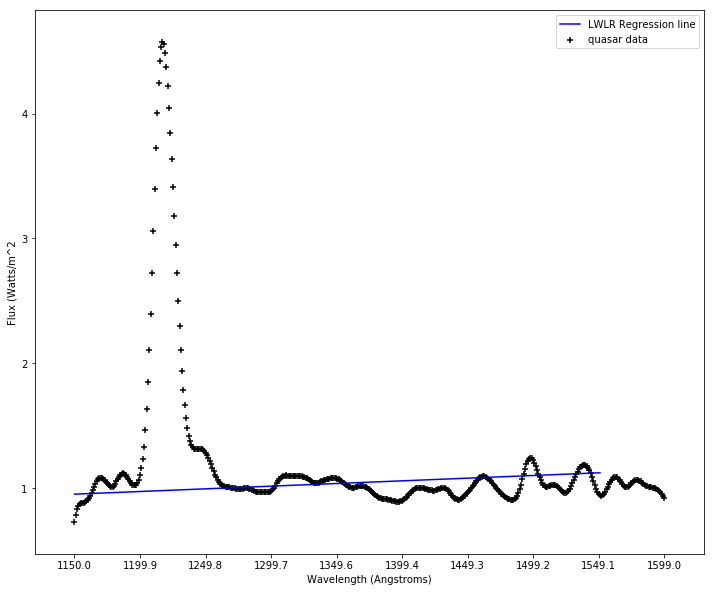

In [52]:
plt.show()

In [23]:
# Training example 6
f5 = mte_eval[5]

In [49]:
fig = plt.figure(1, figsize=(12,10))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Watts/m^2')
plt.xticks(np.linspace(features[0], features[features.shape[0]-1], 10))
plt.yticks(np.linspace(-1, 9, 11))
scatter = plt.scatter(features, f5, marker='+', color='black', label='quasar data')
reg0 = plt.plot(z, f_left(z), color='blue', label='LWLR Regression line')
plt.legend()

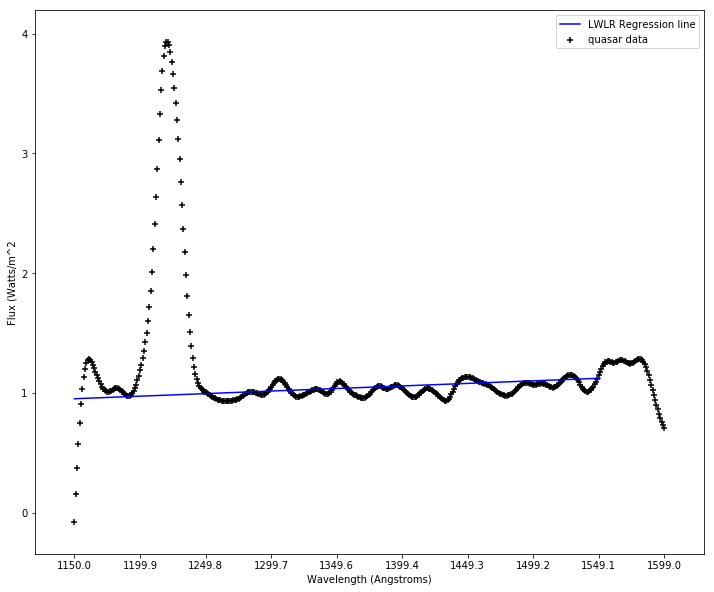

In [50]:
plt.show()